In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [3]:
train= pd.read_csv('../data/interim/train.csv')
train.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,...,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score,credit_age_months,credit_age_years
0,11000.0,11000.0,60,14.64,259.62,C,C3,RENT,Source Verified,debt_consolidation,...,61.2,65.0,4.0,0.0,4.0,0,4.698979,687.0,204,17.000000
1,15000.0,15000.0,36,7.90,469.36,A,A4,MORTGAGE,Verified,debt_consolidation,...,56.8,205.0,9.0,1.0,4.0,0,4.584749,732.0,358,29.833333
2,10000.0,10000.0,36,10.16,323.43,B,B1,RENT,Not Verified,credit_card,...,29.9,33.0,24.0,0.0,4.0,0,4.690205,732.0,349,29.083333
3,13000.0,13000.0,36,9.16,414.37,B,B2,RENT,Source Verified,credit_card,...,70.8,25.0,8.0,0.0,4.0,0,5.021193,677.0,219,18.250000
4,14000.0,14000.0,36,13.67,476.25,B,B5,RENT,Not Verified,debt_consolidation,...,64.4,240.0,12.0,1.0,8.0,0,4.966146,677.0,381,31.750000


In [4]:
train.shape

(570490, 30)

In [5]:
categorical_cols= train.select_dtypes(include='object').columns.tolist()
numerical_cols= train.drop('charged_off', axis=1).select_dtypes(exclude='object').columns.tolist()

train[categorical_cols]= train[categorical_cols].fillna('unknown')
train[numerical_cols]= train[numerical_cols].fillna(train[numerical_cols].mean())

In [6]:
X_train= train.loc[:, train.columns != 'charged_off']
y_train= train['charged_off']

In [7]:
numerical_data= X_train[numerical_cols].copy()

In [8]:
from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
scaled_data= scaler.fit_transform(numerical_data)

In [9]:
distance= []
for k in range(1, 10):
    kmeans= KMeans(n_clusters=k)
    kmeans.fit(scaled_data)
    distance.append(kmeans.inertia_)

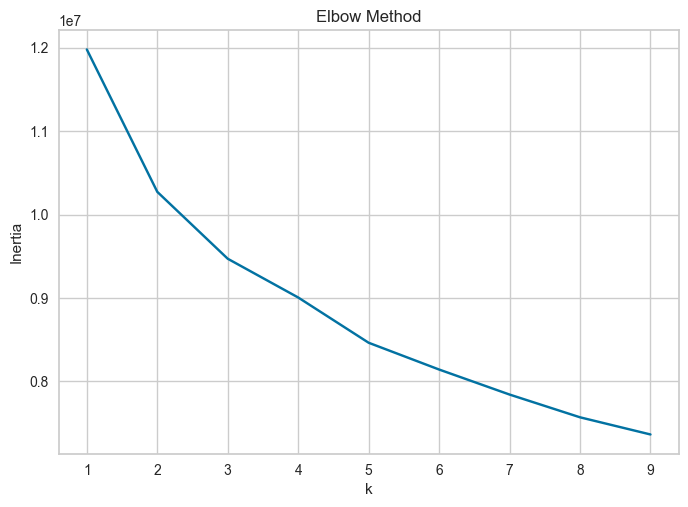

In [10]:
plt.plot(range(1, 10), distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

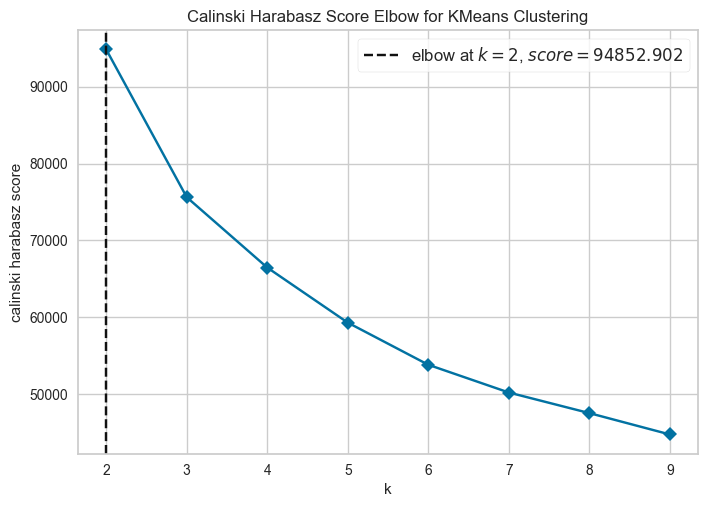

In [11]:
model= KMeans()
visualizer= KElbowVisualizer(model, k=(2, 10), metric='calinski_harabasz', timings=False)
visualizer.fit(scaled_data)
visualizer.show();

In [12]:
kmeans= KMeans(n_clusters=2, random_state=42)
train_clusters= kmeans.fit_predict(scaled_data)

In [13]:
numerical_data['cluster']= train_clusters

In [14]:
X_train= X_train.copy()
X_train['cluster']= numerical_data['cluster']

In [15]:
test= pd.read_csv('../data/interim/test.csv')

In [16]:
test.shape

(244496, 30)

In [17]:
categorical_cols= test.select_dtypes(include='object').columns.tolist()
numerical_cols= test.drop('charged_off', axis=1).select_dtypes(exclude='object').columns.tolist()

test[categorical_cols]= test[categorical_cols].fillna('unknown')
test[numerical_cols]= test[numerical_cols].fillna(test[numerical_cols].mean())

In [18]:
X_test= test.loc[:, test.columns != 'charged_off']
y_test= test['charged_off']

In [19]:
numerical_test= X_test[numerical_cols].copy()
scaled_test= scaler.transform(numerical_test)

X_test['cluster']= kmeans.predict(scaled_test)

In [20]:
train_df= pd.concat([X_train, y_train], axis=1)
test_df= pd.concat([X_test, y_test], axis=1)

In [21]:
print(train_df.shape)
print(test_df.shape)

(570490, 31)
(244496, 31)


In [21]:
train_df.to_csv('../data/processed/final_train.csv', index=False)
test_df.to_csv('../data/processed/final_test.csv', index=False)

In [24]:
cluster_risk= train_df.groupby('cluster')['charged_off'].mean().reset_index()
cluster_risk.columns= ['cluster', 'default_rate']
cluster_risk= cluster_risk.sort_values('default_rate', ascending=True)
cluster_risk['risk_label']= ['Low Risk', 'Medium Risk', 'High Risk'][:len(cluster_risk)]
cluster_risk

,cluster,default_rate,risk_label
0,0,0.197787,Low Risk
1,1,0.210969,Medium Risk


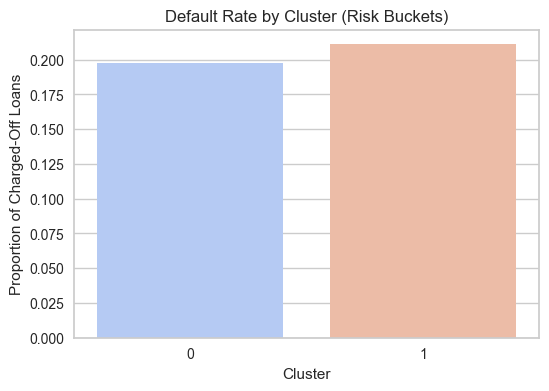

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(6,4))
sns.barplot(data=cluster_risk, x="cluster", y="default_rate", palette="coolwarm")
plt.title("Default Rate by Cluster (Risk Buckets)")
plt.ylabel("Proportion of Charged-Off Loans")
plt.xlabel("Cluster")
plt.show()


In [29]:
train_df2= train_df.copy()


In [30]:
train_df2 = train_df2.merge(cluster_risk, on="cluster", how="left")


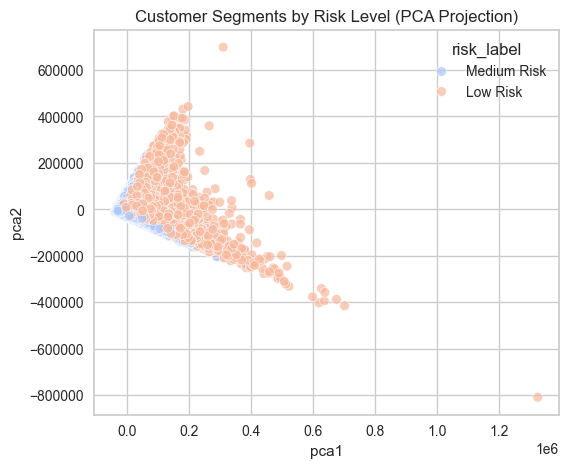

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(train_df2.select_dtypes(float))
train_df2["pca1"], train_df2["pca2"] = pca_features[:,0], pca_features[:,1]

plt.figure(figsize=(6,5))
sns.scatterplot(data=train_df2, x="pca1", y="pca2", hue="risk_label", palette="coolwarm", alpha=0.7)
plt.title("Customer Segments by Risk Level (PCA Projection)")
plt.show()

How Customer segments differ across two principal components:

- Low-Risk borrowers are more widely spread, that is, diverse but stable financial profiles.
- The medium risk cluster is more compact, indicating a narrower group of borrowers with similar moderate risk.

In [32]:
cluster_summary = train_df2.groupby("risk_label")[["loan_amnt", "int_rate", "fico_score", "dti"]].mean().reset_index()
cluster_summary

,risk_label,loan_amnt,int_rate,fico_score,dti
0,Low Risk,22834.534592,14.004598,703.824385,18.169612
1,Medium Risk,9547.027447,13.199932,694.219394,17.695188


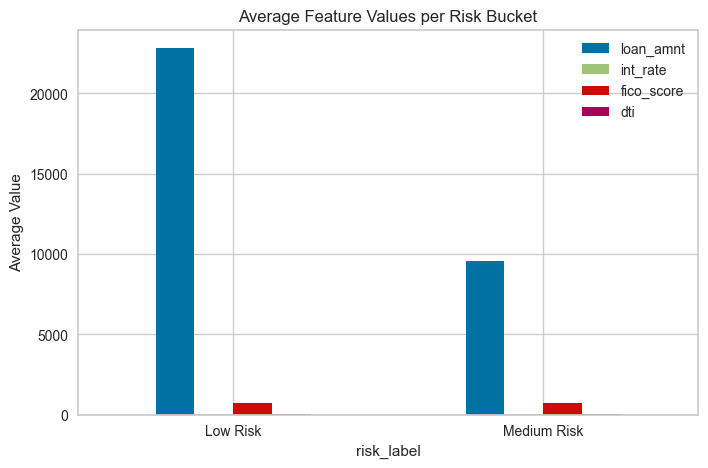

In [33]:
cluster_summary.set_index("risk_label").plot(kind="bar", figsize=(8,5))
plt.title("Average Feature Values per Risk Bucket")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.show()

- Borrowers were segmented based on their credit characteristics
- Although both groups have relatively close default rates, cluster 1 shows a slightly higher likelihood of loan default.
- Borrowers in the low risk cluster take larger loans, have slightly higher FICO scores and maintain manageable dti ratios.
- The ones in the second cluster take smaller loans, have lower credit scores and weaker dti ratios, suggesting weaker creditworthiness.